In [40]:
import pandas as pd
import math, datetime
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv('GOOG.csv', header=0, index_col='Date', parse_dates=True)
print(df.count())
df.head()


Open         2229
High         2229
Low          2229
Close        2229
Adj Close    2229
Volume       2229
dtype: int64


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-30,297.883453,299.542236,297.579590,298.311859,298.311859,1986300
2010-12-31,297.255798,298.092682,294.909607,295.875977,295.875977,3090000
2011-01-03,297.126312,301.664276,297.126312,301.046600,301.046600,4748100
2011-01-04,301.679230,301.958191,298.939514,299.935760,299.935760,3662600
2011-01-05,298.914581,304.025452,298.904633,303.397797,303.397797,5083500


In [46]:
class LinearRegression1():
    def __init__(self, X, y, alpha=0.03, n_iter=1500):

        self.alpha = alpha
        self.n_iter = n_iter
        self.n_samples = len(y)
        self.n_features = np.size(X, 1)
        self.X = np.hstack((np.ones(
            (self.n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))
        self.y = y[:, np.newaxis]
        self.params = np.zeros((self.n_features + 1, 1))
        self.coef_ = None
        self.intercept_ = None

    def fit(self):

        for i in range(self.n_iter):
            self.params = self.params - (self.alpha/self.n_samples) * \
            self.X.T @ (self.X @ self.params - self.y)

        self.intercept_ = self.params[0]
        self.coef_ = self.params[1:]

        return self

    def score(self, X=None, y=None):

        if X is None:
            X = self.X
        else:
            n_samples = np.size(X, 0)
            X = np.hstack((np.ones(
                (n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))

        if y is None:
            y = self.y
        else:
            y = y[:, np.newaxis]

        y_pred = X @ self.params
        score = 1 - (((y - y_pred)**2).sum() / ((y - y.mean())**2).sum())

        return score

    def predict(self, X):
        n_samples = np.size(X, 0)
        y = np.hstack((np.ones((n_samples, 1)), (X-np.mean(X, 0)) \
                            / np.std(X, 0))) @ self.params
        return y

    def get_params(self):

        return self.params

In [41]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume',]]
df['HL_PCT'] = (df['High'] - df['Low'])/df['Low'] * 100
df['PCT_Change'] = (df['Close'] - df['Open'])/df['Open'] * 100
df = df[['Close', 'HL_PCT', 'PCT_Change', 'Volume']]
df.head()

,Close,HL_PCT,PCT_Change,Volume
Date,,,,
2010-12-30,298.311859,0.659536,0.143817,1986300
2010-12-31,295.875977,1.079339,-0.464186,3090000
2011-01-03,301.046600,1.527284,1.319401,4748100
2011-01-04,299.935760,1.009795,-0.577922,3662600
2011-01-05,303.397797,1.713195,1.499832,5083500


In [42]:
forecast_col = 'Close'
df.fillna(-999999, inplace=True)

forecast_out = int(math.ceil(0.01*len(df)))
print(forecast_out)
df['Predicted Claim'] = df[forecast_col].shift(-forecast_out)
(df.head())


23


,Close,HL_PCT,PCT_Change,Volume,Predicted Claim
Date,,,,,
2010-12-30,298.311859,0.659536,0.143817,1986300,304.857330
2010-12-31,295.875977,1.079339,-0.464186,3090000,303.935760
2011-01-03,301.046600,1.527284,1.319401,4748100,304.349213
2011-01-04,299.935760,1.009795,-0.577922,3662600,305.998047
2011-01-05,303.397797,1.713195,1.499832,5083500,308.035400


In [43]:
x = np.array(df.drop(['Predicted Claim'], 1))
y = np.array(df['Predicted Claim'])

x = preprocessing.scale(x)
x = x[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df['Predicted Claim'])

x_lately = x[-forecast_out:]

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.25)
clf = LinearRegression()
clf.fit(X_train, Y_train)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

# regression coefficients 
print('Coefficients: \n', clf.coef_) 
  
accuracy = clf.score(X_test, Y_test)
y_pred = clf.predict(X_test)
print("Linear Regression: ", end=' ')
print(accuracy*100)


Coefficients: 
 [305.95478531   3.31727457  -1.64012629  -6.00012459]
Linear Regression:  97.59933626289353


In [53]:
model1 = LinearRegression1(X_train, Y_train).fit()
print(model1.score())

0.9814463137044965


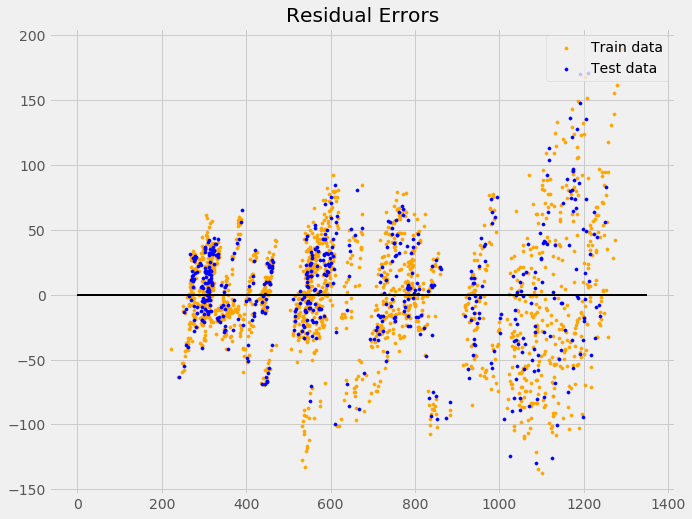

In [45]:
# plot for residual error 

## setting plot style 
plt.style.use('fivethirtyeight') 
  
## plotting residual errors in training data 
plt.scatter(clf.predict(X_train), clf.predict(X_train) - Y_train, color = "orange", s = 10, label = 'Train data') 
  
## plotting residual errors in test data 
plt.scatter(clf.predict(X_test), clf.predict(X_test) - Y_test, color = "blue", s = 10, label = 'Test data') 
  
## plotting line for zero residual error 
plt.hlines(y = 0, xmin = 0, xmax = 1350, linewidth = 2) 
  
## plotting legend 
plt.legend(loc = 'upper right') 
  
## plot title 
plt.title("Residual Errors") 
  
## function to show plot 
plt.show()